<a href="https://colab.research.google.com/github/AdebanjiAdelowo/Roof_segmentation/blob/main/Adelowo_rooftop_segment_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roof Segmentation



We will conduct rooftop segmentation in this notebook by training a model on 25 training samples (consisting of 25 images and 25 masks). Finally, we'll use the trained model to locate the rooftops in five unseen images.

We will perform data augmentation to increase the number of training images and then use Keras to build our model using the u-net architecture from [zhixuhao](https://github.com/zhixuhao/unet). 

We will use the following approach:
* Explore the data
* Preprocess the data (define the data generator)
* Create and train the model 
* Perform rooftop segmentation on the 5 unseen images using the model
* Conclusion


## Setup environment

I have placed the training images and labels (masks) in a training folder and the 5 test images in a test folder. 

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_path='/content/gdrive/My Drive/dida_roof_segmentation_ADELOWO/'
os.chdir(main_path)

Mounted at /content/gdrive


In [2]:
!ls

Adelowo_rooftop_segment.ipynb  data.py	model.py
data			       img	models
dataPrepare.ipynb	       main.py	__pycache__


## Explore the data

Look at one training image and mask. 


Training images:  ['532.png', '379.png', '417.png', '345.png', '381.png', '324.png', '301.png', '343.png', '308.png', '317.png', '315.png', '320.png', '337.png', '328.png', '314.png', '303.png', '300.png', '272.png', '241.png', '121.png', '278.png', '270.png', '284.png', '274.png', '287.png']
Inspect 1 train image
Max value:  1.0
Image shape:  (256, 256, 4)


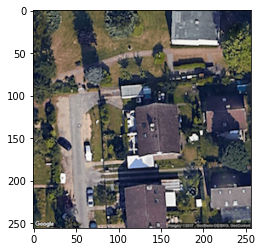

In [3]:
import numpy as np
import matplotlib.pyplot as plt
print('Training images: ', os.listdir("data/train/images"))
print('Inspect 1 train image')
img = plt.imread(os.path.join("data/train/images/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
imgplot = plt.imshow(img)

Inspect 1 train mask
Max value:  1.0
Image shape:  (256, 256)
Pixels in (256,256) img with value 1 : 9200
Pixels in (256,256) img with value 0 : 52917
Pixels in (256,256) img with value between 0 and 1 : 3419


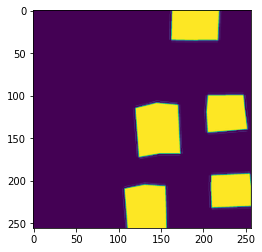

In [4]:
print('Inspect 1 train mask')
img = plt.imread(os.path.join("data/train/labels/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
print('Pixels in (256,256) img with value 1 :',np.sum(img==1.0))
print('Pixels in (256,256) img with value 0 :',np.sum(img==0.0))
print('Pixels in (256,256) img with value between 0 and 1 :',np.sum(img>0.0)-np.sum(img==1.0))
imgplot = plt.imshow(img)

As we see, the mask has values 0, 1 and values between 0 and 1. These last values are in pixels that contain the border of the shape of the roof. 

In [5]:
DATA_DIR = 'data'

DATA_DIR = os.path.join(DATA_DIR)

TRAIN_DATA_DIR = os.path.join(DATA_DIR,  'train' )

TEST_DATA_DIR = os.path.join(DATA_DIR,  'test' )

AUG_DATA_DIR =  os.path.join(DATA_DIR,  'train/augs' )

MODEL_PATH = os.path.join('models/unet_dida.hdf5')

# Train your Unet with dida house data

## Define the data generator

As we only have 25 training images, we will use ImageDataGenerator for data augmentation. 

Based on a couple of runs I have selected the (basic) augmentation settings and batch_size=20 below. 

We set seed=1 to make sure that the augmented images correspond to the right augmented masks.


### Train with data generator

In [6]:
import sys
sys.path.append(main_path)
from data import *

In [7]:
data_gen_args = dict(rotation_range=0.2,  
                    width_shift_range=0.05, 
                    height_shift_range=0.05,
                    shear_range=0.05, 
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGenerator = trainGenerator(20, TRAIN_DATA_DIR ,'images','labels', data_gen_args, image_color_mode = 'rgba', save_to_dir = None)

In [8]:
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


### Visualize the data generator

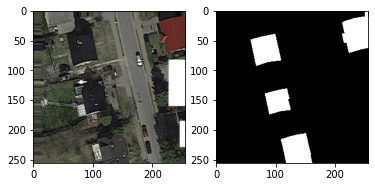

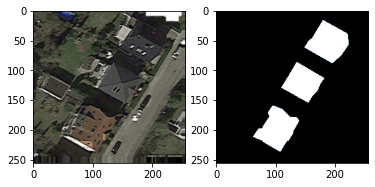

In [9]:
# check if images images are zipped
batch_size = 2
for b in range(1):
    example = next(myGenerator)
    for i in range(batch_size):
      img=example[0][i]
      mask=example[1][i]
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img.squeeze(), cmap=plt.get_cmap('bone'))
      ax[1].imshow(mask.squeeze(), cmap=plt.get_cmap('bone'))
      fig.show()

In [10]:
mask=example[1][0]
print('Verify only 1 and 0 in mask:\n')
print('pix in mask with value 1 :',np.sum(mask==1.0))
print('pix in mask with value 0 :',np.sum(mask==0.0))
print('pix in mask with value no 0 or 1 :',np.sum(mask>0.0)-np.sum(mask==1.0))

Verify only 1 and 0 in mask:

pix in mask with value 1 : 7634
pix in mask with value 0 : 57902
pix in mask with value no 0 or 1 : 0


# Define & train the model

We use the u-net architecture from [zhixuhao](https://github.com/zhixuhao/unet) and train our model for 2 epochs with 2000 steps per epoch (of batch_size 20). This setup was chosen after running the model for a couple of different epochs, steps_per_epoch and batch_sizes. 

In [11]:
from model import *

PRETRAINED_PATH = os.path.join('models/copy_one_unet_dida.hdf5')

model = unet(pretrained_weights = PRETRAINED_PATH, input_size = (256,256,4))

model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='loss', verbose = 1, save_best_only=True)

model.fit(myGenerator, steps_per_epoch = 2000, epochs=5, callbacks=[model_checkpoint])

## Test the model and save the predicted results

We will finally test the model and try to find the roofs on 5 test images in test/images directory.


In [12]:
IMAGE_DIR = os.path.join(TEST_DATA_DIR, 'images')

test_path = TEST_DATA_DIR

image_folder = 'images'

image_color_mode ='rgba'

target_size=(256,256)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = 1,
        seed = 1)
 
filenames = [os.path.basename(x) for x in test_generator.filenames]
print(filenames)
num_images = filenames
testGene = testGenerator(IMAGE_DIR, num_images = num_images, as_gray = False)
model = unet(input_size = (256,256,4))
#model.load_weights(PRETRAINED_PATH)
model.load_weights(MODEL_PATH)
results = model.predict(testGene, verbose = 1)

Found 5 images belonging to 1 classes.
['535.png', '537.png', '539.png', '551.png', '553.png']
5/5 [==============================] - 9s 2s/step


In [13]:
SAVE_DIR = os.path.join(TEST_DATA_DIR, 'labels')
saveResult(SAVE_DIR, filenames, results)

## Test the model on dida test data and save the predicted results

We will finally test the model and try to find the roofs on 5 test images in test/dida_images directory.


In [14]:
image_folder = 'dida_images'

IMAGE_DIR = os.path.join(TEST_DATA_DIR, image_folder)
testGene = testGenerator(IMAGE_DIR, num_images = num_images, as_gray = False)
results = model.predict(testGene, verbose =1 ) #steps = test_samples, verbose=1)

5/5 [==============================] - 9s 2s/step


In [15]:
save_path = os.path.join(TEST_DATA_DIR, 'dida_labels')
saveResult(save_path, filenames, results) #(results*255).astype(np.uint8), filenames)

In [16]:
print("Thank You")

Thank You


## Conclusion

The results of the rooftop segmentation are quite good. After visually comparing the test masks/labels to the images we see that they are quite accurate.

Some possible improvements for the future would be: checking if we could get better results by using a different architecture or altering the current u-net model or, using transfer learning with a model with pre-trained weights for rooftop segmentation. 
